In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PARQ_PATH = "data/imdb/parquet/"

FILES_IMDB_PARQ = {
    "tit_bas" : "title_basics.parquet",
    "genres" : "genres.parquet",
    "tit_rate" : "title_ratings.parquet",
    'directors' : 'directors.parquet',
    'writers' : 'writers.parquet',
    'prim_prof' : 'primary_profession.parquet',
    'known_for' : 'known_for_titles.parquet',
    'name_bas' : 'name_basics.parquet',
    'const' : 'ids.parquet',
    'ordering' : 'ordering.parquet',
    'character' : 'character.parquet',
    'job' : 'job.parquet',
}

FILES_HAND = {
    "add_seen": "add_movies_seen.txt", # old
    "add_unseen": "add_movies_unseen.txt", # old
    "add_secop": "add_movies_second_opinion.txt", # old
    "raw_status": "raw_status.xlsx",
    "to_add" : "to_add.xlsx"
}

FILES_GENERATED = {
    "films_raw": "films_raw.pkl",
    "films_reading": "films_reading.xlsx"
}

# Training set

We will take the training set and look at how we will clean it.
Then we will look at the test set

In [3]:
def setAttr(frame):
    # setting column types
    frame['watched_date'] = pd.to_datetime(frame['watched_date'])
    frame['enjoyment'] = frame['enjoyment'].astype(float)
    frame['watched'] = frame['watched'].astype("Int64").replace(0,np.nan)
    frame[['netflix','prime','priority']] = frame[['netflix','prime','priority']].astype("Int64")
    frame = frame.drop_duplicates()
    return frame

# loading and preparing film list
raw_stat_link = os.path.join("data", "handcrafted", FILES_HAND["raw_status"])
raw_stat = pd.read_excel(raw_stat_link)
raw_stat = setAttr(raw_stat)
raw_stat = raw_stat.set_index("tconst")

In [4]:
# get constants
const_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["const"])
const = pd.read_parquet(const_url)

# get id's of personal scores
enjoyment = scores = raw_stat[~raw_stat['enjoyment'].isna()]['enjoyment']
intids = const[const.index.isin(enjoyment.index)]["intid"]
enjoyment = pd.merge(intids, enjoyment, left_index=True, right_index=True, how="inner")

In [5]:
del const
del raw_stat

# 1) title basics

In [5]:
# get title basics
tit_bas_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["tit_bas"])
tit_bas = pd.read_parquet(tit_bas_url)

# filter
enjoyment_tit_bas = tit_bas[tit_bas.index.isin(enjoyment['intid'])]

In [6]:
enjoyment_tit_bas.isna().sum()

titleType           0
primaryTitle        0
originalTitle       0
isAdult             0
startYear           0
endYear           214
runtimeMinutes      1
dtype: int64

the endYear column can be removed.

## 1.1) titleType

<AxesSubplot:>

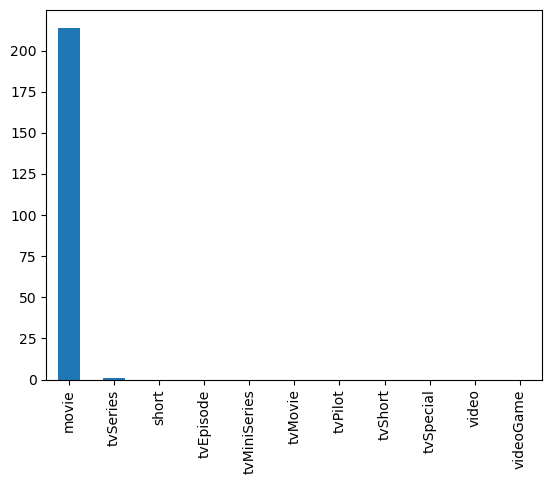

In [7]:
enjoyment_tit_bas['titleType'].value_counts().plot.bar()

TitleType doesn't realy matter, but that's mostly bias because i didn't put tv shows in the dataset. But I also don't really care about the type of media. I will remove it and can always filter results later.

## 1.2) PrimaryTitle and originalTitle
we will just drop these columns, because they are way too annoying to analyze.

## 1.3) isAdult
I will remove every media that is adult, i'm not interested in this.

In [8]:
enjoyment_tit_bas[enjoyment_tit_bas['isAdult']]

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes
tconst,,,,,,,


## 1.4) startyear and endyear

<AxesSubplot:ylabel='Frequency'>

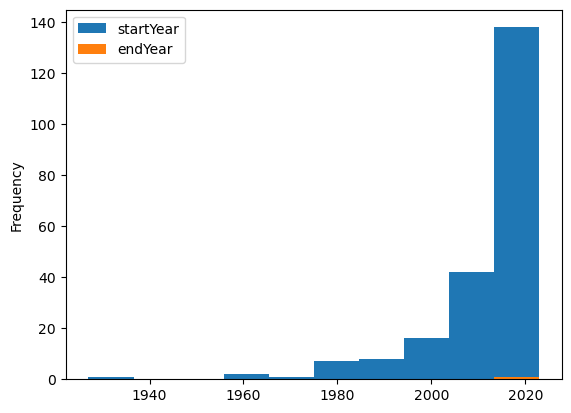

In [9]:
enjoyment_tit_bas[['startYear','endYear']].plot.hist()

## 1.6) runtimeMinutes

<AxesSubplot:ylabel='Frequency'>

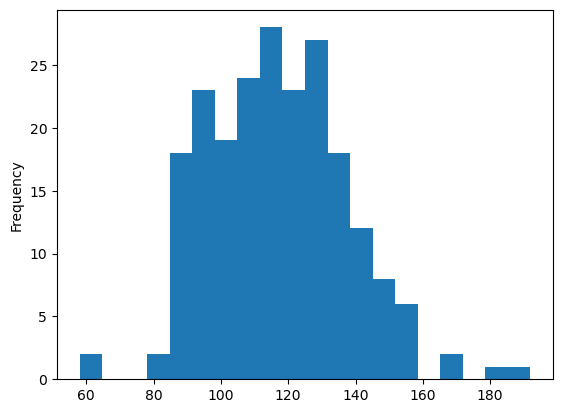

In [10]:
enjoyment_tit_bas['runtimeMinutes'].plot.hist(bins=20)

this looks like a poisson distribution, but could also be two distributions mixed together. I also have a feeling this correlates with genre or startYear.

# 2) genres

In [16]:
# get genres data
genres_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["genres"])
genres = pd.read_parquet(genres_url)

# # filter
genres_watched = genres[genres.index.isin(enjoyment['intid'])]

<AxesSubplot:xlabel='genre'>

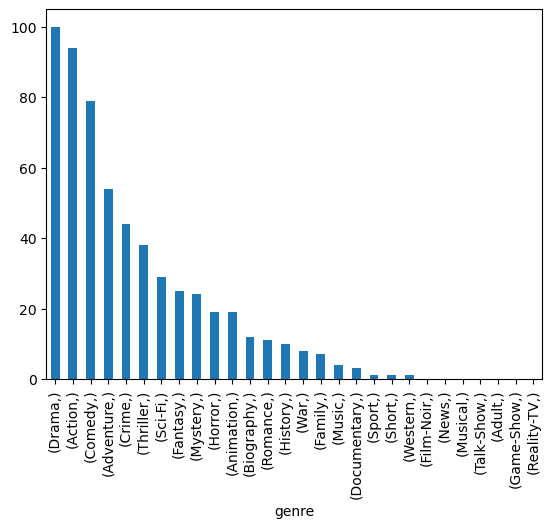

In [22]:
genres_watched.value_counts().plot.bar()

* maybe remove all genres with less counts than animation.

## 3) title rate

<AxesSubplot:>

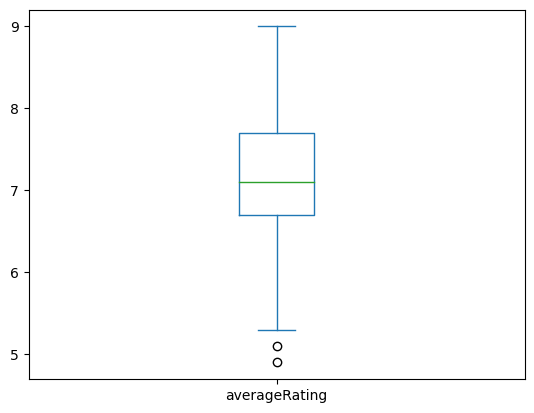

In [36]:
# get title rate data
tit_rate_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["tit_rate"])
tit_rate = pd.read_parquet(tit_rate_url)

# filter
tit_rate_watched = tit_rate[tit_rate.index.isin(enjoyment['intid'])]

# plot
tit_rate_watched['averageRating'].plot.box()

<AxesSubplot:>

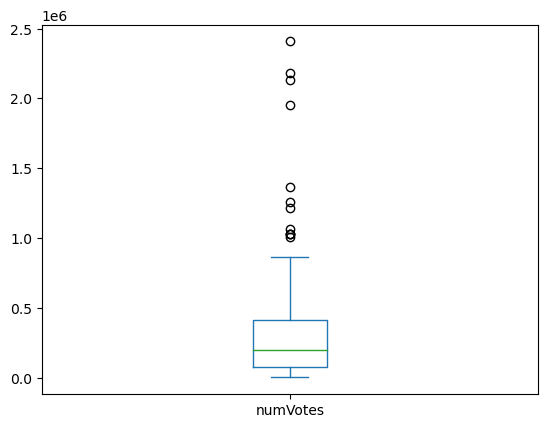

In [35]:
tit_rate_watched['numVotes'].plot.box()

## 4) Directors

In [73]:
# get title rate data
directors_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["directors"])
directors = pd.read_parquet(directors_url)

# convert
directors = directors.astype('category')

# count
list_directors = directors[directors.index.isin(enjoyment['intid'])]
counts = list_directors['directors'].value_counts()
counts.value_counts()

0    749919
1       162
2        16
3         8
4         5
Name: directors, dtype: int64

There aren't that many directors that occur multiple times, so we just take all directors.

## 5) Writers

In [85]:
# get title rate data
writers_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["writers"])
writers = pd.read_parquet(writers_url)

# convert
writers = writers.astype('category')

# count
list_writers = writers[writers.index.isin(enjoyment['intid'])]
counts = list_writers['writers'].value_counts()
counts.value_counts()

0    956358
1       412
2        61
3        11
4         8
6         2
Name: writers, dtype: int64

again, we take all writers

## 6) ordering

In [8]:
# get oredering data
ordering_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["ordering"])
ordering = pd.read_parquet(ordering_url)

list_ordering = ordering[ordering.index.isin(enjoyment['intid'])]

<AxesSubplot:>

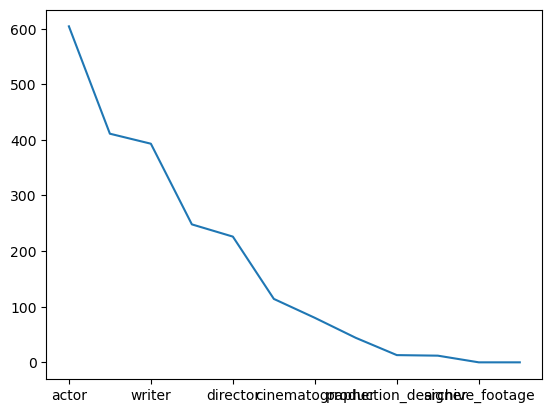

In [19]:
list_ordering.category.value_counts().plot()

let's remove everything with less occurances than director

In [20]:
list_ordering.category.value_counts()

actor                  604
producer               411
writer                 393
actress                248
director               226
composer               114
cinematographer         80
editor                  44
production_designer     13
self                    12
archive_footage          0
archive_sound            0
Name: category, dtype: int64

Keep: actor, producer, writer, actress, director

Let's see what are the top 3 categories, accoriding to the ordering.

In [25]:
list_ordering[list_ordering.ordering < 4].category.value_counts()

actor                  445
actress                191
self                     9
archive_footage          0
archive_sound            0
cinematographer          0
composer                 0
director                 0
editor                   0
producer                 0
production_designer      0
writer                   0
Name: category, dtype: int64

So it's mostly about the actors and actresses.
We could give all the actors and actresses a score an basis of the ordering.

Who appear the most?

In [28]:
list_ordering['nconst'].value_counts()

206        12
5351        8
748784      6
1116660     6
1165110     6
           ..
2538611     1
8752173     1
9827373     1
1443502     1
1928263     1
Name: nconst, Length: 1740, dtype: Int64

In [31]:
# get name basics data
name_bas_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["name_bas"])
name_bas = pd.read_parquet(name_bas_url)

name_bas.loc[206]

primaryName    Keanu Reeves
birthYear              1964
deathYear              <NA>
Name: 206, dtype: object

that explains a lot

In [37]:
counts = list_ordering['nconst'].value_counts()
name_bas[name_bas.index.isin(counts[counts > 5].index)]

,primaryName,birthYear,deathYear
nconst,,,
168,Samuel L. Jackson,1948,<NA>
206,Keanu Reeves,1964,<NA>
437,Woody Harrelson,1961,<NA>
5351,Ryan Reynolds,1976,<NA>
412588,Basil Iwanyk,1970,<NA>
748784,Scott Rudin,1958,<NA>
1014201,Rhett Reese,<NA>,<NA>
1116660,Paul Wernick,<NA>,<NA>
1165110,Chris Hemsworth,1983,<NA>


In [40]:
list_ordering['nconst'].value_counts().value_counts()

1     1477
2      177
3       59
4       15
6        7
5        3
12       1
8        1
Name: nconst, dtype: Int64

In [41]:
ordering

,nconst,ordering,category
tconst,,,
1,1588970,1,self
1,5690,2,director
1,374658,3,cinematographer
2,721526,1,director
2,1335271,2,composer
...,...,...,...
9916880,996406,5,director
9916880,584014,6,director
9916880,1482639,7,writer


## 7) name basics

In [6]:
# load names and birth / death year
name_bas_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["name_bas"])
name_bas = pd.read_parquet(name_bas_url)

# get needed data
list_name_bas = name_bas[name_bas.index.isin(list_ordering['nconst'])]

<AxesSubplot:>

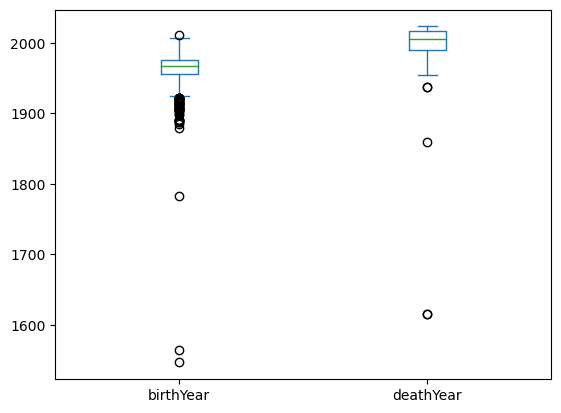

In [21]:
list_name_bas[['birthYear','deathYear']].plot.box()


missing birthyear will be replaced with 
We must replace outliers and missing values with the median.

In [39]:
list_name_bas[['birthYear', 'deathYear']].isna().value_counts().unstack()

deathYear,False,True
birthYear,,
False,122,1048
True,2,568


We must remove values that don't have a birthyear or deathyear (568).
we remove the values that have no birthyear but have a deathyear, because there are only 2.
There are a lot of values that don't have a deathyear.
we can replace deathyear with an 'is alive column' and an age at filming column.

## 8) primaryProfession

In [22]:
# get title basics
ordering_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["ordering"])
ordering = pd.read_parquet(ordering_url)

# filter
list_personnel = ordering[ordering.index.isin(enjoyment['intid'])]['nconst']

# get primary profession
prim_prof_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["prim_prof"])
prim_prof = pd.read_parquet(prim_prof_url)

# get needed professions
list_professions = prim_prof[prim_prof.index.isin(list_personnel.unique())]

del prim_prof
del ordering
del list_personnel

<AxesSubplot:xlabel='primaryProfession'>

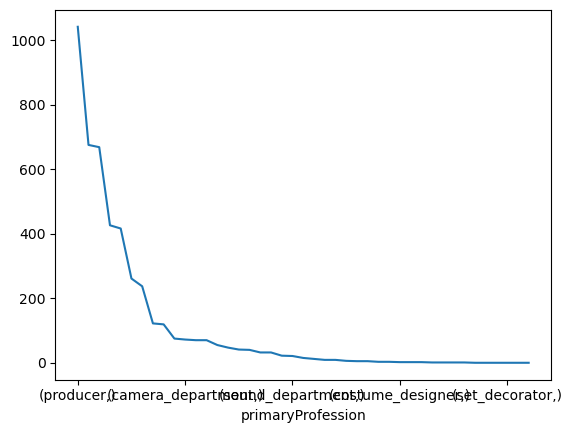

In [26]:
list_professions.value_counts().plot()

we remove everything less than 100

In [29]:
counts = list_professions.value_counts()
counts = counts[counts > 100]
counts

primaryProfession
producer             1041
writer                675
actor                 668
soundtrack            426
director              416
miscellaneous         261
actress               237
music_department      122
composer              119
dtype: int64

## 9) known for titles

In [10]:
# get title basics
ordering_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["ordering"])
ordering = pd.read_parquet(ordering_url)

# filter
enjoyment_ordering = ordering[ordering.index.isin(enjoyment['intid'])]

In [11]:
enjoyment_ordering

,nconst,ordering,category
tconst,,,
17136,2111404,10,composer
17136,375609,1,actress
17136,2154,2,actor
17136,297054,3,actor
17136,459030,4,actor
...,...,...,...
9806192,3021346,5,director
9806192,491011,6,writer
9806192,238941,7,producer


In [12]:
# get known_for
known_for_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["known_for"])
known_for = pd.read_parquet(known_for_url)

# filter
list_known_for = known_for[known_for.index.isin(enjoyment_ordering['nconst'])]

In [13]:
list_known_for

,knownForTitles
nconst,
4,80455
4,72562
4,77975
4,78723
20,82846
...,...
9946633,9506474
9946633,8680242
9946633,12879304


In [14]:
list_known_for.value_counts()

knownForTitles
4154796           17
2015381           16
5323662           14
1375666           13
3896198           13
                  ..
758774             1
762073             1
765010             1
765120             1
27789824           1
Length: 3865, dtype: int64

most are known from avengers: endgame, guardians of the galaxy, a silent voice.<br>
WE CAN USE THIS FILE TO INCREASE THE ACTORS PER MOVIE!!!

## 11) directors

the files have different information about the directors.
<br><b>title basics:</b>

In [15]:
# get title basics
directors_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["directors"])
directors = pd.read_parquet(directors_url)

# filter
enjoyment_directors = directors[directors.index.isin(enjoyment['intid'])]

In [16]:
len(enjoyment_directors)

238

In [34]:
enjoyment_directors

,directors
tconst,
17136,485
50083,1486
52357,33
66434,184
73195,229
...,...
9506474,1717924
9686708,31976
9764362,617042


<b>ordering:</b>

In [17]:
# get oredering data
ordering_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["ordering"])
ordering = pd.read_parquet(ordering_url)

list_ordering = ordering[ordering.index.isin(enjoyment['intid'])]

In [18]:
list_ordering = list_ordering[list_ordering['category'] == 'director']
len(list_ordering)

226

<b>job:</b>

In [19]:
# get job data
job_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["job"])
job = pd.read_parquet(job_url)

In [20]:
jobs = job['job'].unique().tolist()
[s for s in jobs if "director" in s]

['director of photography',
 'co-director',
 'film director',
 'collaborating director',
 'director: 1916 shooting',
 'director: 1914 shooting',
 'co-director: 1916 shooting',
 'editorial director',
 'animation director',
 'director: retakes',
 'supervising director',
 'Interview with director',
 'additional director',
 'replacement director',
 'dialogue director',
 'second director',
 'animation director: earlier cartoon clips',
 'director: Megaphone',
 'fill-in director',
 'director: African exteriors',
 'director: some scenes',
 'producing director',
 'sequence director',
 'original director',
 'also music director',
 'co-director: alpine scenes',
 'segment director',
 'director: Kansas scenes',
 'director of photography: exteriors',
 'director: additional scenes',
 'series director',
 'edit director',
 'director: medical footage',
 'consultant to the director',
 'main director',
 'creative director',
 'director: "Shine" sequence',
 'sequence director: animation',
 'the director of 

This is a mess.
There is a lot of information that can be used, but the job categories need to be cleaned first.

In [23]:
list_job = job[job.index.isin(enjoyment['intid'])]
list_job[list_job['job']=='director']

,nconst,job
tconst,,


let's look at the ordering and title basics directors

In [24]:
enjoyment_directors.drop_duplicates()

,directors
tconst,
17136,485
50083,1486
52357,33
66434,184
73195,229
...,...
9506474,1717924
9686708,31976
9764362,617042


In [25]:
ordering_directors = list_ordering[list_ordering['category'] == 'director']['nconst']
ordering_directors = ordering_directors.to_frame().rename(columns={"nconst":"directors"})
ordering_directors.drop_duplicates()

,directors
tconst,
17136,485
50083,1486
52357,33
66434,184
73195,229
...,...
9506474,1717924
9686708,31976
9764362,617042


In [26]:
pd.concat([enjoyment_directors.drop_duplicates(), ordering_directors.drop_duplicates()]).drop_duplicates()

,directors
tconst,
17136,485
50083,1486
52357,33
66434,184
73195,229
...,...
9506474,1717924
9686708,31976
9764362,617042


In [33]:
ordering_directors.drop_duplicates().value_counts()

directors
33           1
815204       1
822582       1
844301       1
851930       1
            ..
307497       1
315117       1
318916       1
319659       1
7743299      1
Length: 181, dtype: int64

So the ordering file does not contain all the info.
We will just use the directors file for the directors.

In [37]:
enjoyment_directors.drop_duplicates().value_counts().sort_values()

directors
33           1
386          1
116          1
154          1
165          1
            ..
4170048      1
4186854      1
5165413      1
3230448      1
7743299      1
Length: 191, dtype: int64

so far there haven't been any directors that appeared two times in the rated watch list

## 12) writers

In [11]:
# get title basics
writers_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["writers"])
writers = pd.read_parquet(writers_url)

# filter
enjoyment_writers = writers[writers.index.isin(enjoyment['intid'])]

In [12]:
enjoyment_writers.drop_duplicates()

,writers
tconst,
17136,902376
17136,485
50083,741627
52357,178785
52357,853138
...,...
9764362,2219721
9764362,4301557
9783600,2808422


In [13]:
# get oredering data
ordering_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["ordering"])
ordering = pd.read_parquet(ordering_url)

list_ordering = ordering[ordering.index.isin(enjoyment['intid'])]

list_ordering = list_ordering[list_ordering['category'] == 'writer']
len(list_ordering)

393

In [14]:
ordering_writers = list_ordering[list_ordering['category'] == 'writer']['nconst']
ordering_writers = ordering_writers.to_frame().rename(columns={"nconst":"writers"})
ordering_writers.drop_duplicates()

,writers
tconst,
17136,902376
50083,741627
52357,27173
52357,178785
52357,853138
...,...
9686708,3461468
9764362,2219721
9764362,4301557


In [15]:
pd.concat([enjoyment_writers.drop_duplicates(), ordering_writers.drop_duplicates()]).drop_duplicates()

,writers
tconst,
17136,902376
17136,485
50083,741627
52357,178785
52357,853138
...,...
9764362,2219721
9764362,4301557
9783600,2808422


We are better of using the writers file, for the same reason wit the directors file.

In [16]:
ordering_writers.drop_duplicates().value_counts()

writers 
233         1
1709264     1
1894782     1
1854069     1
1843538     1
           ..
569199      1
568825      1
568313      1
565068      1
12470578    1
Length: 342, dtype: int64

## 10) characters

In [6]:
# get nconst
ordering_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["ordering"])
ordering = pd.read_parquet(ordering_url)
list_ordering = ordering[ordering.index.isin(enjoyment['intid'])]["nconst"].to_frame()
list_ordering = list_ordering.reset_index(level=0)
del ordering

In [13]:
list_ordering

,tconst,nconst
0,17136,2111404
1,17136,375609
2,17136,2154
3,17136,297054
4,17136,459030
...,...,...
2140,9806192,3021346
2141,9806192,491011
2142,9806192,238941
2143,9806192,1776887


In [8]:
# get characters data
characters_url = os.path.join(PARQ_PATH, FILES_IMDB_PARQ["character"])
characters = pd.read_parquet(characters_url).reset_index(level=0)
characters

,tconst,nconst,characters
0,1,1588970,Self
1,5,443482,Blacksmith
2,5,653042,Assistant
3,8,653028,Sneezing Man
4,9,63086,Miss Geraldine Holbrook (Miss Jerry)
...,...,...,...
28224963,9916880,254176,Moody Margaret
28224964,9916880,286175,Dad
28224965,9916880,286175,Aerobic Al
28224966,9916880,286175,Nasty Nicola


In [19]:
pd.merge(list_ordering, characters, how="left", left_on=["tconst","nconst"],right_on=["tconst","nconst"])

,tconst,nconst,characters
0,17136,2111404,NaN
1,17136,375609,Maria
2,17136,375609,Maschinenmensch
3,17136,375609,The Machine Man
4,17136,2154,Johann (Joh) Fredersen
...,...,...,...
2205,9806192,3021346,NaN
2206,9806192,491011,NaN
2207,9806192,238941,NaN
2208,9806192,1776887,NaN


without removing null values, you get 2210 results out off 2145 queries. which is weird.

# Correlations

## 1) startYear and runtimeMinutes

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

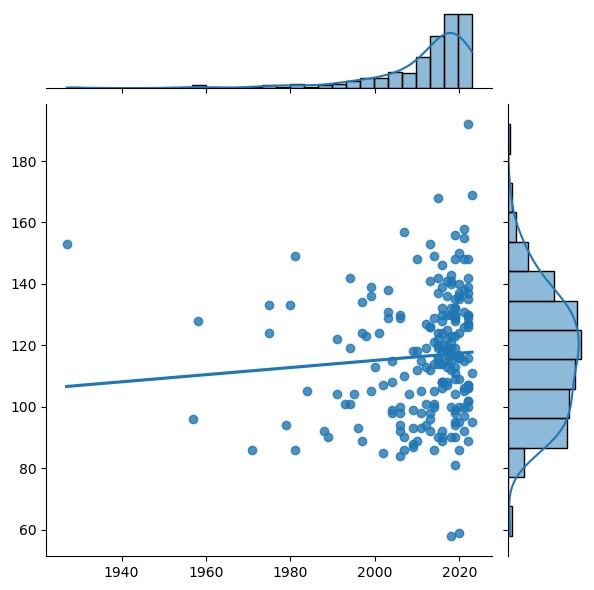

In [67]:
sns.jointplot(x=enjoyment_tit_bas.startYear.to_list(), y=enjoyment_tit_bas.runtimeMinutes.to_list(), kind='reg', dropna=True)
plt.show()

There is not much of a relation. Let's try the cluster plot.

/home/user/ManualInstalls/anaconda3/envs/ML/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/home/user/ManualInstalls/anaconda3/envs/ML/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
/home/user/ManualInstalls/anaconda3/envs/ML/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/home/user/ManualInstalls/anaconda3/envs/ML/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, t

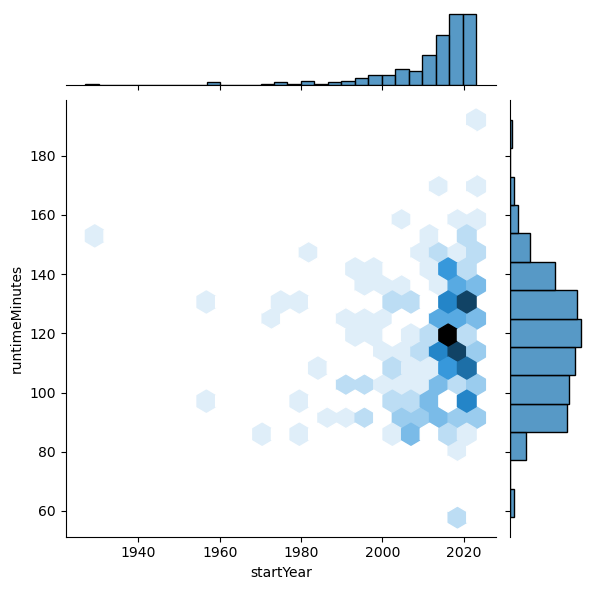

In [68]:
sns.jointplot(data=enjoyment_tit_bas, x='startYear', y='runtimeMinutes', kind='hex', dropna=True)
plt.show()

There is a cluster around 130 and 110 minutes. Let's remove outlying startYears and runtime minutes.

## 2) genre and X

Maybe there is a realtion between runtimeMinutes, startYear and genre, let's look into that later.

## Let's look at missing values

In [12]:
tit_bas.isna().sum()

titleType               0
primaryTitle           11
originalTitle          11
isAdult                 0
startYear         1331622
endYear           9757636
runtimeMinutes    6954967
dtype: int64

<AxesSubplot:title={'center':'missing values for title_basics'}>

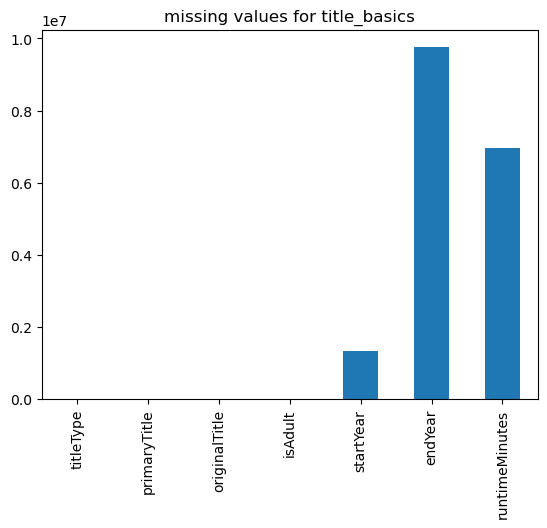

In [15]:
tit_bas.isna().sum().plot.bar(title="missing values for title_basics")

let's look at the missing titles

In [24]:
tit_bas[tit_bas["primaryTitle"].isna() | tit_bas["originalTitle"].isna()]

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes
tconst,,,,,,,
14510930,tvEpisode,<NA>,<NA>,False,<NA>,<NA>,<NA>
15700278,tvEpisode,<NA>,<NA>,False,2021,<NA>,<NA>
1971246,tvEpisode,<NA>,<NA>,False,2011,<NA>,<NA>
2067043,tvEpisode,<NA>,<NA>,False,1965,<NA>,<NA>
21883066,tvEpisode,<NA>,<NA>,False,2022,<NA>,<NA>
2305914,tvEpisode,<NA>,<NA>,False,<NA>,<NA>,<NA>
2305918,tvEpisode,<NA>,<NA>,False,<NA>,<NA>,<NA>
5773048,tvEpisode,<NA>,<NA>,False,2015,<NA>,<NA>
8473688,tvEpisode,<NA>,<NA>,False,1987,<NA>,<NA>


<li>We will remove rows with missing primaryTitle and missing OriginalTitle </li>